<a href="https://colab.research.google.com/github/didulabhanuka/Tomato-Ripeness-Classifier/blob/main/Faster_R_CNN_tomato_ripeness_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Cell 1: Install Required Libraries

In [ ]:
!pip install ultralytics albumentations torchvision pycocotools fiftyone torchmetrics
!pip install flask

Cell 2: Import Required Libraries & Mount Google Drive

In [ ]:
import os
import cv2
import json
import yaml
import torch
import random
import shutil
import zipfile
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from matplotlib.backends.backend_pdf import PdfPages
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_recall_fscore_support
from albumentations import Compose, RandomBrightnessContrast, HueSaturationValue, GaussianBlur, MotionBlur, Normalize


from google.colab import drive
drive.mount('/content/drive')

Cell 3: YAML File Creation

In [ ]:
yaml_content = """
train: /content/dataset_augmented/train
val: /content/dataset_augmented/val

nc: 6
names: ["b_fully_ripened", "b_half_ripened", "b_green", "l_fully_ripened", "l_half_ripened", "l_green"]
"""

yaml_path = "/content/tomato_ripeness_classifier.yaml"
with open(yaml_path, "w") as file:
    file.write(yaml_content)

print(f"YAML file created at {yaml_path}")

Cell 4: Dataset Unzipping

In [ ]:
dataset_zip = "/content/drive/MyDrive/tomato_ripeness_classifier/tomato_dataset.zip"
dataset_dir = "/content/dataset/dataset"

os.makedirs("/content/dataset", exist_ok=True)
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

print("Dataset unzipped successfully.")

Cell 5: Dataset Augmentation

In [ ]:
# Define dataset paths
augmented_dir = "/content/dataset_augmented"

# Create Augmented Dataset Folders
os.makedirs(f"{augmented_dir}/train/images", exist_ok=True)
os.makedirs(f"{augmented_dir}/train/labels", exist_ok=True)
os.makedirs(f"{augmented_dir}/val/images", exist_ok=True)
os.makedirs(f"{augmented_dir}/val/labels", exist_ok=True)

def denormalize_image(image):
    """
    Reverts normalization to bring pixel values back to [0,255].
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Undo normalization
    image = image * std + mean  # Reverse normalization
    image = np.clip(image * 255, 0, 255).astype(np.uint8)  # Convert to 0-255 range

    return image

def validate_and_clip_bbox(bbox, img_w, img_h):
    """
    Ensures bounding box values stay within valid ranges.
    """
    x_center, y_center, width, height = bbox
    x_center /= img_w
    y_center /= img_h
    width /= img_w
    height /= img_h

    x_center = np.clip(x_center, 0.0, 1.0)
    y_center = np.clip(y_center, 0.0, 1.0)
    width = np.clip(width, 0.0, 1.0)
    height = np.clip(height, 0.0, 1.0)

    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2

    if 0.0 <= x_min <= 1.0 and 0.0 <= y_min <= 1.0 and 0.0 <= x_max <= 1.0 and 0.0 <= y_max <= 1.0 and width > 0 and height > 0:
        return [x_center, y_center, width, height]
    return None  # Invalid bbox

def advanced_augmentations(image_folder, label_folder, output_image_folder, output_label_folder):
    """
    Applies augmentations while keeping bounding boxes correctly aligned.
    """
    augmentations = Compose(
        [
            RandomBrightnessContrast(p=0.2),
            HueSaturationValue(p=0.2),
            GaussianBlur(p=0.1),
            MotionBlur(p=0.1),
            Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Applied for training
        ],
        bbox_params={"format": "yolo", "label_fields": ["class_labels"]},
    )

    for image_file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, os.path.splitext(image_file)[0] + ".txt")

        # Read the image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Skipping {image_file}: Unable to read image.")
            continue

        h, w, _ = image.shape
        bboxes = []
        class_labels = []

        # Read the bounding boxes
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, x_center, y_center, width, height = map(float, line.strip().split())
                    valid_bbox = validate_and_clip_bbox([x_center * w, y_center * h, width * w, height * h], w, h)
                    if valid_bbox:
                        bboxes.append(valid_bbox)
                        class_labels.append(int(cls))

        if not bboxes:
            print(f"Skipping image {image_file} due to no valid bounding boxes.")
            continue

        # Apply Augmentations
        augmented = augmentations(image=image, bboxes=bboxes, class_labels=class_labels)
        augmented_image = augmented["image"]
        augmented_bboxes = augmented["bboxes"]
        augmented_class_labels = augmented["class_labels"]

        # 🔹 Fix Black Image Issue: Convert Back to uint8 before saving
        augmented_image = denormalize_image(augmented_image)

        # Save Augmented Image
        output_img_path = os.path.join(output_image_folder, image_file)
        cv2.imwrite(output_img_path, augmented_image)

        # Save Updated Labels
        output_label_path = os.path.join(output_label_folder, os.path.splitext(image_file)[0] + ".txt")
        with open(output_label_path, "w") as f:
            for bbox, cls in zip(augmented_bboxes, augmented_class_labels):
                x_center, y_center, width, height = bbox
                f.write(f"{cls} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        print(f"Saved Augmented Image: {output_img_path}")

# Apply Augmentation to Train and Validation Sets
dataset_dir = "/content/dataset/dataset"
advanced_augmentations(
    image_folder=f"{dataset_dir}/train/images",
    label_folder=f"{dataset_dir}/train/labels",
    output_image_folder=f"{augmented_dir}/train/images",
    output_label_folder=f"{augmented_dir}/train/labels"
)

advanced_augmentations(
    image_folder=f"{dataset_dir}/val/images",
    label_folder=f"{dataset_dir}/val/labels",
    output_image_folder=f"{augmented_dir}/val/images",
    output_label_folder=f"{augmented_dir}/val/labels"
)

print("✅ Augmentation completed successfully.")

Cell 6: Test Augmentation on a Random Image

In [ ]:
def check_random_augmented_image(image_folder, label_folder):
    """
    Selects a random augmented image, loads its bounding boxes, and visualizes it.
    """
    image_files = os.listdir(image_folder)
    if not image_files:
        print("No augmented images found!")
        return

    # Select a random image
    random_image = random.choice(image_files)
    img_path = os.path.join(image_folder, random_image)
    label_path = os.path.join(label_folder, os.path.splitext(random_image)[0] + ".txt")

    # Load the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error loading image: {random_image}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    h, w, _ = image.shape  # Get image dimensions

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image)

    # Load bounding boxes and draw them
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls, x_center, y_center, width, height = map(float, line.strip().split())

                # Convert YOLO format to pixel coordinates
                x_center *= w
                y_center *= h
                width *= w
                height *= h

                x_min = x_center - width / 2
                y_min = y_center - height / 2

                rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"Class: {int(cls)}", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.title(f"Augmented Image: {random_image}")
    plt.show()

# Run the function to check a random augmented image
check_random_augmented_image(
    image_folder="/content/dataset_augmented/train/images",
    label_folder="/content/dataset_augmented/train/labels"
)


Cell 7: Train Faster R-CNN

In [ ]:
# 1. Define the dataset
class TomatoDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.image_filenames[idx].replace('.jpg', '.txt'))

        image = Image.open(img_path).convert("RGB")

        # Reduce image size for faster training
        image = transforms.Resize((600, 600))(image)  # Resize to smaller size (e.g., 600x600)
        image = transforms.ToTensor()(image)

        img_w, img_h = image.shape[2], image.shape[1]  # Width, Height

        boxes, labels = [], []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, x_center, y_center, width, height = map(float, line.strip().split())

                    # Denormalize bounding box coordinates
                    x_center *= img_w
                    y_center *= img_h
                    width *= img_w
                    height *= img_h

                    # Convert to [x_min, y_min, x_max, y_max] format
                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2

                    boxes.append([x_min, y_min, x_max, y_max])  # Use denormalized coordinates
                    labels.append(int(cls) + 1)

        target = {"boxes": torch.tensor(boxes, dtype=torch.float32), "labels": torch.tensor(labels, dtype=torch.int64)}
        return image, target

# 2. Create the train and validation datasets
train_dataset = TomatoDataset(f"{augmented_dir}/train/images", f"{augmented_dir}/train/labels")
val_dataset = TomatoDataset(f"{augmented_dir}/val/images", f"{augmented_dir}/val/labels")

# 3. DataLoader with lower batch size
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# 4. Model initialization function
def get_faster_rcnn_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Initialize the model
num_classes = 7  # 6 classes + 1 for background
model = get_faster_rcnn_model(num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 5. Optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 6. Mixed precision training setup
scaler = GradScaler()  # Initialize GradScaler for mixed precision

# 7. Training with early stopping
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    for images, targets in tqdm(data_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Use autocast for mixed precision training
        with autocast():
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        # Scale the loss and backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# Early stopping parameters
best_loss = float('inf')
patience = 3  # Stop after 3 epochs with no improvement
patience_counter = 0
num_epochs = 10  # Start with a small number of epochs for experimentation

# 8. Training loop with early stopping
for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader, device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")

    # Check for improvement in loss
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0
        # **Create the directory if it doesn't exist before saving the model**
        model_save_path = "/content/drive/MyDrive/tomato_ripeness_classifier/fasterrcnn_tomato_model/model.pth"
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

        # Save the model if it improves
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")
    else:
        patience_counter += 1

    # Early stopping if no improvement for 'patience' epochs
    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# 9. Saving configuration (optional)
project_dir = "/content/drive/MyDrive/tomato_ripeness_classifier/fasterrcnn_tomato_model"
os.makedirs(project_dir, exist_ok=True)

config = {
    "num_classes": num_classes,
    "epochs": num_epochs,
    # "optimizer_state_dict": optimizer.state_dict(),  # Remove this line
    "batch_size": 2,
    "image_size": (600, 600),
    "early_stopping_patience": patience
}

config_save_path = os.path.join(project_dir, "config.json")
with open(config_save_path, "w") as f:
    json.dump(config, f)

print(f"Configuration saved to {config_save_path}")



Cell 8: Model Evaluation

In [ ]:
# 10. Evaluation function
def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Perform inference
            outputs = model(images)

            for i in range(len(outputs)):
                pred_boxes = outputs[i]['boxes'].cpu().numpy()
                pred_labels = outputs[i]['labels'].cpu().numpy()
                pred_scores = outputs[i]['scores'].cpu().numpy()

                true_boxes = targets[i]['boxes'].cpu().numpy()
                true_labels = targets[i]['labels'].cpu().numpy()

                all_preds.append((pred_boxes, pred_labels, pred_scores))
                all_labels.append((true_boxes, true_labels))

    # Now, compute the precision and recall using predicted and true boxes/labels
    # You can define a function to compute precision, recall, and F1 score for each class.
    precision, recall, f1 = compute_precision_recall_f1(all_preds, all_labels)

    return precision, recall, f1

# Function to compute precision, recall, and F1-score for the given predictions
def compute_precision_recall_f1(all_preds, all_labels):
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for preds, labels in zip(all_preds, all_labels):
        pred_boxes, pred_labels, pred_scores = preds
        true_boxes, true_labels = labels

        # For simplicity, you can use a common IoU threshold (e.g., 0.5) to determine true positives
        iou_threshold = 0.5
        tp, fp, fn = 0, 0, 0

        for i, true_box in enumerate(true_boxes):
            matched = False
            for j, pred_box in enumerate(pred_boxes):
                # Calculate IoU (Intersection over Union)
                iou = compute_iou(true_box, pred_box)
                if iou >= iou_threshold:
                    matched = True
                    break

            if matched:
                tp += 1
            else:
                fn += 1

        fp = len(pred_boxes) - tp  # False positives are the remaining predictions

        # Precision, Recall, and F1 Calculation
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)
    avg_f1 = np.mean(all_f1s)

    return avg_precision, avg_recall, avg_f1

# Compute IoU
def compute_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    # Compute the area of the intersection
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Compute the area of both boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Compute IoU
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

# 11. Run evaluation
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
precision, recall, f1 = evaluate(model, val_loader, device)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Cell 9: Model Inference and Visualization

Predicted Labels (indices): [6 3 6 6 4 1 6 3 3 3 6 3 6 2 3 2 5 5 6 1]
Predicted Scores: [    0.96853     0.84371     0.81484     0.81453     0.68249     0.53816     0.52694     0.51034     0.46406     0.37317     0.30708     0.26252     0.22468     0.15543     0.11414    0.093389    0.092948    0.074241    0.052006    0.050705]
Filtered Boxes: [[     839.44      2739.2      1201.5      3125.3]
 [     1511.5        2340      1935.4      2778.7]
 [     892.61      2038.7      1416.7      2562.5]
 [     1225.9      1418.5      1759.1      1981.3]
 [       1624      1230.5      2085.8      1809.3]
 [       1616      1233.1      2103.4      1793.9]
 [     1506.8      2352.9      1946.8      2776.6]
 [     1226.6      1418.4      1758.2      1974.6]]
Filtered Labels: [6 3 6 6 4 1 6 3]


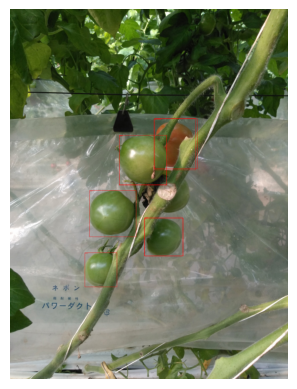

Inference complete. Saved result to /content/IMG_20191215_112403.jpg_pred.jpg.


In [ ]:
# Load the YAML file to get class names
yaml_path = "/content/tomato_ripeness_classifier.yaml"
with open(yaml_path, "r") as file:
    yaml_content = yaml.safe_load(file)  # Use safe_load for security

class_names = yaml_content["names"]  # This will give you the class names list

# Load the trained model
model_path = "/content/drive/MyDrive/tomato_ripeness_classifier/fasterrcnn_tomato_model/model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

# Set device for model inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the image folder and get a random image
test_image_folder = "/content/dataset_augmented/val/images"
image_files = os.listdir(test_image_folder)

if not image_files:
    print("No images found in the validation set!")
else:
    # Ensure the selected image has valid bounding boxes
    while True:
        random_image = random.choice(image_files)
        label_path = os.path.join(test_image_folder.replace("images", "labels"), os.path.splitext(random_image)[0] + ".txt")
        if os.path.exists(label_path):
            break

    image_path = os.path.join(test_image_folder, random_image)

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension

    # Run inference on the image
    with torch.no_grad():
        outputs = model(image_tensor)

    # Get the predictions (boxes, labels, and scores)
    boxes = outputs[0]['boxes'].cpu().numpy()
    labels = outputs[0]['labels'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()

    # Print out predictions for debugging
    print("Predicted Labels (indices):", labels)
    print("Predicted Scores:", scores)

    # Filter predictions with a confidence score greater than a threshold (e.g., 0.5)
    threshold = 0.5
    boxes = boxes[scores >= threshold]
    labels = labels[scores >= threshold]

    # Print the filtered boxes and corresponding labels
    print("Filtered Boxes:", boxes)
    print("Filtered Labels:", labels)

    # Draw bounding boxes and class names on the image
    draw = ImageDraw.Draw(image)
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

        # Map the predicted label to the class name using the YAML class names
        class_name = class_names[label - 1]  # Adjust if labels are 0-indexed
        draw.text((x_min, y_min), class_name, fill="red")

    # Show the resulting image
    plt.imshow(image)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

    # Save the resulting image
    output_image_path = f"/content/{random_image}_pred.jpg"
    image.save(output_image_path)

    print(f"Inference complete. Saved result to {output_image_path}.")